## CCA
#### Imports

In [1]:
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import scipy.stats as sts 
from sklearn.decomposition import PCA
from statsmodels.multivariate.cancorr import CanCorr

from helpers import *
import cca_helpers

In [2]:
trial_colors = {'ah':'mediumblue',
               'wh':'forestgreen',
               'wm':'crimson',
               'fa':'k',
               'cr':'dimgray'}

#### Get behavioural and neural data

In [3]:
data_path =  '../data/'

verbose = True

# Load trial data
fname = 'ab042_trial_data.csv'
trial_df = pd.read_csv(os.path.join(data_path,fname))
trial_df.head()

trial_type_list = ['ah', 'wh','wm','fa','cr']
if verbose:
    for trial_type in trial_type_list:
        print('Trial type, {}, #trials = {}'.format(trial_type, sum(trial_df[trial_type])))
        

# Load neuron data for list of areas
fname = 'ab042_cluster_spike_times.csv'
neuron_df = pd.read_csv(os.path.join(data_path,fname))
areas = np.unique(neuron_df.area, return_counts=True)
area_list = areas[0]

if verbose:
    print(areas)

# Load spike count data

fname = 'ab042_spikes_dense.npy'
spike_array = np.load(os.path.join(data_path,fname))
print(spike_array.shape)


Trial type, ah, #trials = 83
Trial type, wh, #trials = 42
Trial type, wm, #trials = 140
Trial type, fa, #trials = 36
Trial type, cr, #trials = 211
(array(['DLS', 'DS', 'OFC', 'Thalamus', 'nS1', 'tjM1', 'wM2', 'wS1'],
      dtype=object), array([135,  30,  72, 139, 121, 166, 126,  58]))
(847, 512, 401)


#### Get per-area matrices

In [4]:

all_psths = {}

for trial_type in trial_type_list:
    all_psths[trial_type] = {}
    trial_indices = trial_df[trial_df[trial_type]==1].index.values

    for area in area_list:
        neuron_indices = neuron_df[neuron_df.area==area].index.values

        spike_array_sub = spike_array[neuron_indices][:,trial_indices,:]
        all_psths[trial_type][area] = spike_array_sub

if verbose:
    for area in all_psths["ah"].keys():
        print(area, all_psths["ah"][area].shape)

DLS (135, 83, 401)
DS (30, 83, 401)
OFC (72, 83, 401)
Thalamus (139, 83, 401)
nS1 (121, 83, 401)
tjM1 (166, 83, 401)
wM2 (126, 83, 401)
wS1 (58, 83, 401)


#### PSTHs

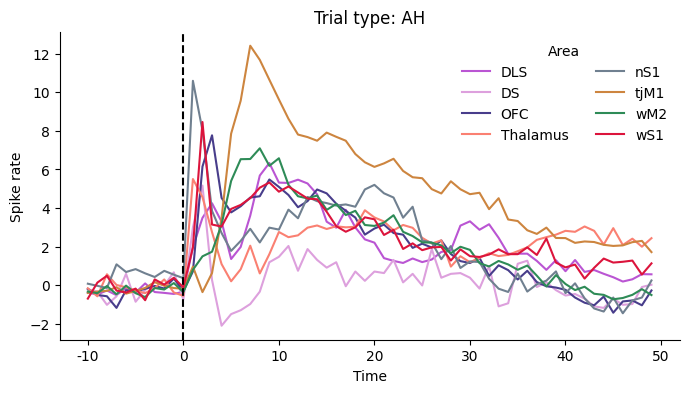

In [5]:
trial_start_idx = 200
pre_win = 10
start_idx = trial_start_idx - pre_win
post_win = 50
stop_idx = trial_start_idx + post_win

#print(trial_start_idx, start_idx, stop_idx)
for trial_type in trial_type_list:

    if trial_type != 'ah':
        continue
        
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        spike_array_area = all_psths[trial_type][area] 
        spike_array_sub_bas = spike_array_area[:,:,0:100]
        baseline = np.mean(spike_array_sub_bas)
        spike_array_area_correct = spike_array_area - baseline
        mean_spike_rate = (np.mean(spike_array_area_correct, axis=(0,1))) / 0.01
        mean_spike_rate = mean_spike_rate[start_idx:stop_idx]
        
        # Plot
        ax.plot(mean_spike_rate,
                color=get_area_color(area),
                label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type.upper()))
    ax.axvline(x=trial_start_idx - start_idx, ls='--',c='k')
    x_ticks = np.arange(0, pre_win+post_win+1) 
    x_ticks = x_ticks[::10]
    x_labels = np.arange(-pre_win, +post_win+1)
    x_labels = x_labels[::10]
    #print(x_ticks, x_labels)
    ax.set_xticks(ticks=x_ticks,
                 labels=x_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    plt.legend(title='Area', frameon=False, ncol=2)
    
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True))


#### PSTH smoothed

(35,)
(35,)
(35,)
(35,)
(35,)
(35,)
(35,)
(35,)


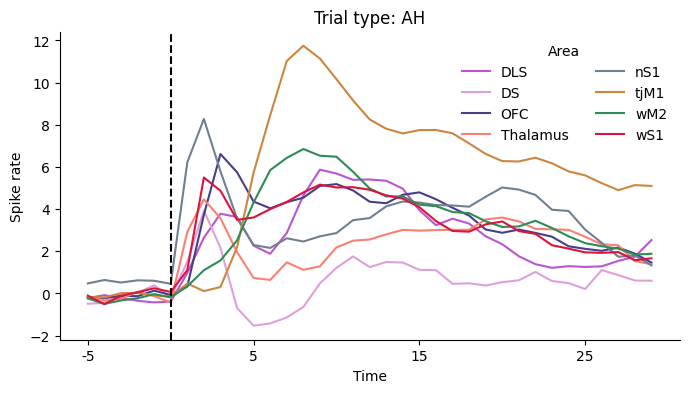

In [6]:
smooth = True
smooth_sigma = 1


trial_start_idx = 200
pre_win = 5
start_idx = trial_start_idx - pre_win
post_win = 30
stop_idx = trial_start_idx + post_win

#print(trial_start_idx, start_idx, stop_idx)
for trial_type in trial_type_list:

    if trial_type != 'ah':
        continue
        
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        spike_array_area = all_psths[trial_type][area] 
        spike_array_sub_bas = spike_array_area[:,:,0:100]
        baseline = np.mean(spike_array_sub_bas)
        spike_array_area_correct = spike_array_area - baseline
        mean_spike_rate = (np.mean(spike_array_area_correct, axis=(0,1))) / 0.01
        mean_spike_rate = mean_spike_rate[start_idx:stop_idx]
        
        # Plot
        print(mean_spike_rate.shape)
        if smooth:
            mean_spike_rate = halfgaussian_filter1d(mean_spike_rate, sigma=smooth_sigma)
            
        ax.plot(mean_spike_rate,
                color=get_area_color(area),
                label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type.upper()))
    ax.axvline(x=trial_start_idx - start_idx, ls='--',c='k')
    x_ticks = np.arange(0, pre_win+post_win+1) 
    x_ticks = x_ticks[::10]
    x_labels = np.arange(-pre_win, +post_win+1)
    x_labels = x_labels[::10]
    #print(x_ticks, x_labels)
    ax.set_xticks(ticks=x_ticks,
                 labels=x_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    plt.legend(title='Area', frameon=False, ncol=2)
    

(126, 83, 401)


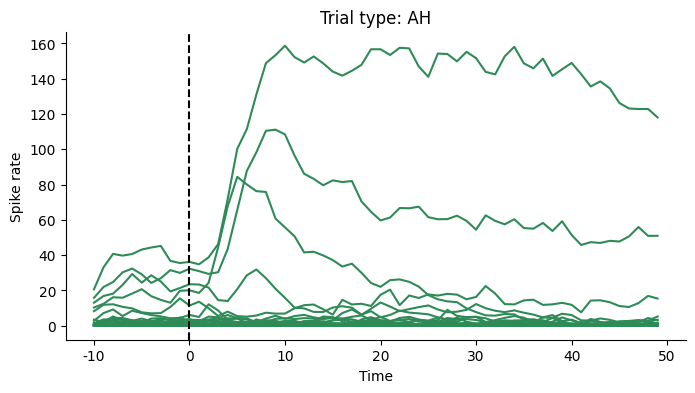

In [7]:
smooth = True


trial_start_idx = 200
pre_win = 10
start_idx = trial_start_idx - pre_win
post_win = 50
stop_idx = trial_start_idx + post_win

#print(trial_start_idx, start_idx, stop_idx)
for trial_type in trial_type_list:

    if trial_type != 'ah':
        continue
        
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    ax.spines[['right', 'top']].set_visible(False)

    for area in area_list:
        if area != 'wM2':
            continue
            
        spike_array_area = all_psths[trial_type][area] 
        spike_array_sub_bas = spike_array_area[:,:,0:100]
        baseline = np.mean(spike_array_sub_bas)
        print(spike_array_area.shape)
        spike_array_area_correct = spike_array_area - baseline
        
        for t_idx in range(spike_array_area.shape[0])[::5]:
            
            trial_spikes = np.mean(spike_array_area[t_idx,:,:], axis=0) / 0.01
            trial_spikes = trial_spikes[start_idx:stop_idx]
        
            # Plot
            if smooth:
                trial_spikes = halfgaussian_filter1d(trial_spikes, sigma=smooth_sigma)

            ax.plot(trial_spikes,
                    color=get_area_color(area),
                    label=area)


    # Legend
    ax.set_title('Trial type: {}'.format(trial_type.upper()))
    ax.axvline(x=trial_start_idx - start_idx, ls='--',c='k')
    x_ticks = np.arange(0, pre_win+post_win+1) 
    x_ticks = x_ticks[::10]
    x_labels = np.arange(-pre_win, +post_win+1)
    x_labels = x_labels[::10]
    ax.set_xticks(ticks=x_ticks,
                 labels=x_labels)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spike rate')
    #plt.legend(title='Area', frameon=False, ncol=2)
    

### Smooth and select data slices, and reshape in 2D (trial concat.)

In [8]:
area_1 = 'tjM1'
area_2 = 'DLS'
trial_type = 'ah'

trial_start_idx = 200
pre_win = 10
start_idx = trial_start_idx - pre_win
post_win = 100
stop_idx = trial_start_idx + post_win

kernal_sigma = 1


def slice_array(spike_array, pre_start_bins, post_start_bins, smooth=True, smooth_kernel=5):
    """
    Slice spike array

    Parameters
    ----------
    spike_array : Neurons x trials x time_bins
        spike count matrix
    pre_start_bins : number of bins before trial start
    post_start_bins : number of bins before trial start
    smooth: whether to smooth
    smooth_kernel: window size in (in bins; 1 bin=10ms)
    
    Returns
    -------

    spike_array_processed
    -> slices spike array
    """
    n_neurons = spike_array.shape[0]
    n_trials = spike_array.shape[1]
    spike_array_processed = []

    trial_start_idx = 200

    start_idx = trial_start_idx - pre_start_bins - smooth_kernel # to take border artefact into account
    stop_idx =  trial_start_idx + post_start_bins + smooth_kernel
    
    for neur_idx in range(n_neurons):
        spike_array_trial = []
        for t_idx in range(n_trials):
            trial_spikes = spike_array[neur_idx, t_idx, start_idx : stop_idx]            
            
            if smooth:
                trial_spikes = convolve_1d(trial_spikes, kernel_size=smooth_kernel)
                
            spike_array_trial.append(trial_spikes[smooth_kernel:-smooth_kernel])
        spike_array_processed.append(spike_array_trial)    
    
    return np.asarray(spike_array_processed)
    

spike_array_area_1 = all_psths[trial_type][area_1] 
n_trials = spike_array_area_1.shape[1]
spike_array_area_smooth_1 = slice_array(spike_array_area_1, pre_win, post_win, smooth=True, smooth_kernel=5)

spike_array_area_2 = all_psths[trial_type][area_2] 
spike_array_area_smooth_2 = slice_array(spike_array_area_2, pre_win, post_win, smooth=True, smooth_kernel=5)

print('Preprocessed data shapes:', spike_array_area_smooth_1.shape, spike_array_area_smooth_2.shape)

Preprocessed data shapes: (166, 83, 110) (135, 83, 110)


#### Example neuron before and after smoothing:

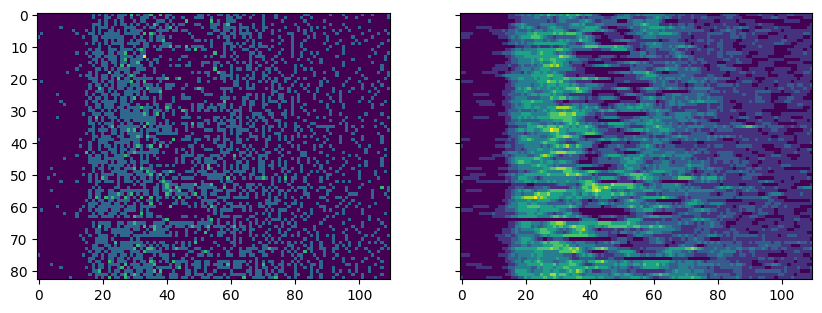

In [9]:
neur_idx=10
fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
axs[0].imshow(spike_array_area_1[neur_idx,:,start_idx:stop_idx])
axs[1].imshow(spike_array_area_smooth_1[neur_idx,:,:])

#### Split train-test (trials), reshape and center data

In [10]:
def split_reshape(X):
    """
    Split into train-test and reshape 2D
    X: neurons x trials x time bins
    """
    
    #print(X.shape)
    n_trials = X.shape[1]
    #print(n_trials)
    if n_trials % 2 == 1:
        n_trials -= 1
    
    #print(n_trials)
    # Shuffle-split
    idx = np.arange(n_trials)
    np.random.shuffle(idx)
    X = X[:,idx,:]
    X_tr, X_te = X[:,n_trials//2:,:], X[:,:n_trials//2,:]
    
    # Reshape
    
    X_tr = X_tr.reshape(X_tr.shape[0], -1)
    X_te = X_te.reshape(X_te.shape[0], -1)

    return X_tr, X_te

In [11]:
print('Before reshape', spike_array_area_smooth_1.shape, spike_array_area_smooth_2.shape)
X_1_tr, X_1_te = split_reshape(spike_array_area_smooth_1)
X_2_tr, X_2_te = split_reshape(spike_array_area_smooth_2)
print(X_1_tr.shape, X_1_te.shape)
print(X_2_te.shape, X_2_te.shape)

print('After reshape', X_1_tr.shape, X_1_te.shape)

Before reshape (166, 83, 110) (135, 83, 110)
(166, 4510) (166, 4510)
(135, 4510) (135, 4510)
After reshape (166, 4510) (166, 4510)


#### Remove means

In [12]:
X_1_tr = X_1_tr - X_1_tr.mean(axis=1)[:,np.newaxis]
X_1_te = X_1_te - X_1_tr.mean(axis=1)[:,np.newaxis] # from train data ???

X_2_tr = X_2_tr - X_2_tr.mean(axis=1)[:,np.newaxis]
X_2_te = X_2_te - X_2_tr.mean(axis=1)[:,np.newaxis] # from train data

print(X_1_tr.shape, X_1_te.shape, X_2_tr.shape, X_2_te.shape)

(166, 4510) (166, 4510) (135, 4510) (135, 4510)


### Align using CCA

#### PCA: have an idea of number of components to keep

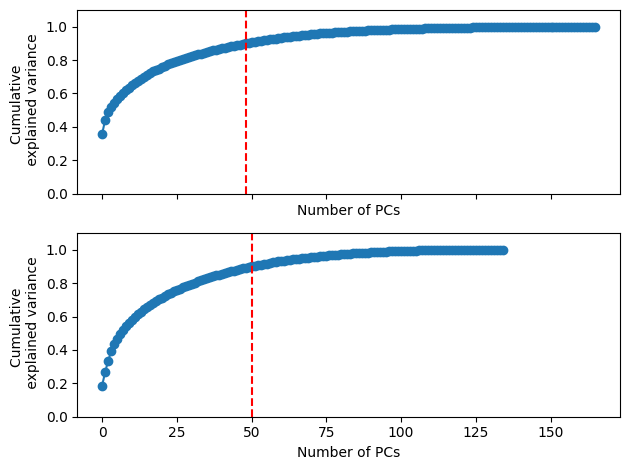

In [24]:
pca_tjm1 = PCA()
pca_tjm1.fit(X_1_tr.T)

pca_dls = PCA()
pca_dls.fit(X_2_tr.T)

fig, axs = plt.subplots(2,1, sharex=True)
for ax in axs.flat:
    ax.set_ylim(0,1.1)
    ax.set_ylabel('Cumulative \n explained variance')
    ax.set_xlabel('Number of PCs')
    
axs[0].plot(np.cumsum(pca_tjm1.explained_variance_ratio_), marker="o")
axs[0].axvline(np.argmin(np.abs(np.cumsum(pca_tjm1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
axs[1].plot(np.cumsum(pca_dls.explained_variance_ratio_), marker="o")
axs[1].axvline(np.argmin(np.abs(np.cumsum(pca_dls.explained_variance_ratio_)-0.9)), linestyle="--", c="red")

plt.tight_layout()

In [25]:
n_pcs=50

print('Input:', X_1_tr.T.shape, X_2_tr.T.shape)
axes_area_1, axes_area_2, A_1_tr, A_2_tr, cc = cca_helpers.align(X_1_tr.T, X_2_tr.T, m=n_pcs, cv=False)
cc = np.asarray(cc)
#print(axes_area_1.shape, axes_area_2.shape, A_1.shape, A_2.shape, cc.shape)

A_1_te = X_1_te.T @ axes_area_1
A_2_te = X_2_te.T @ axes_area_2

print('Output train', A_1_tr.shape, A_2_tr.shape)
print('Output test', A_1_te.shape, A_2_te.shape)

Input: (4510, 166) (4510, 135)
Output train (4510, 50) (4510, 50)
Output test (4510, 50) (4510, 50)


Text(0, 0.5, 'Canonical correlation')

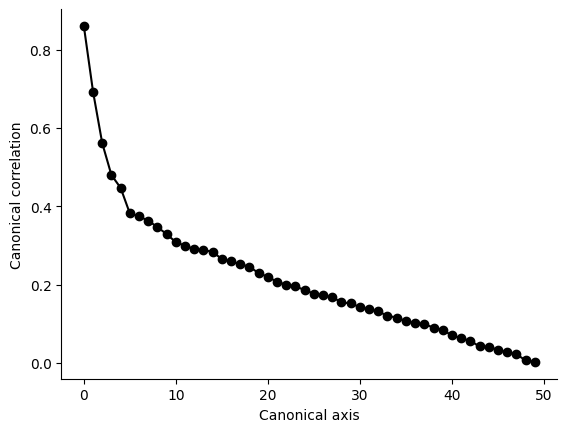

In [26]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.plot(cc, marker='o', c='k')
ax.set_xlabel('Canonical axis')
ax.set_ylabel('Canonical correlation')

Post-align shapes:
Train (4510, 50) (4510, 50)
Test (4510, 50) (4510, 50)
Post-align reshape:
(41, 110, 50) (41, 110, 50)


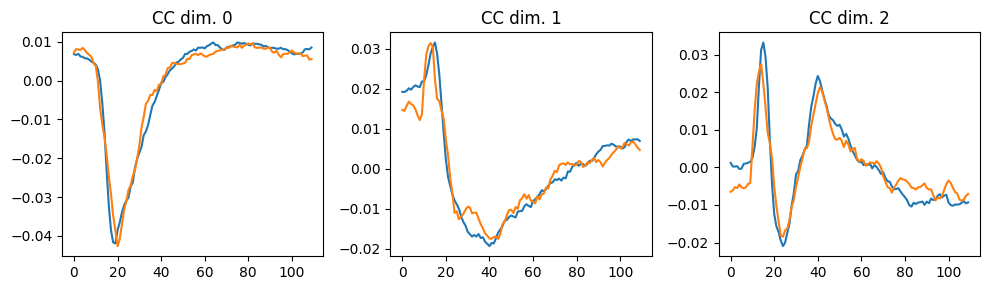

In [31]:
#A_1 = X_1.T @ axes_area_1
#A_2 = X_2.T @ axes_area_2
print('Post-align shapes:')
print('Train', A_1_tr.shape, A_2_tr.shape)
print('Test', A_1_te.shape, A_2_te.shape)

A_1_trials = A_1_tr.reshape(n_trials, -1, A_1_tr.shape[1])
A_2_trials = A_2_tr.reshape(n_trials, -1, A_2_tr.shape[1])

print('Post-align reshape:')
print(A_1_trials.shape, A_2_trials.shape)

fig, axs = plt.subplots(1,3, figsize=(10,3), sharex=False, sharey=False)
for cc_dim in range(3):
    axs[cc_dim].set_title('CC dim. {}'.format(cc_dim))
    axs[cc_dim].plot(np.mean(A_1_trials, axis=0)[:,cc_dim])
    axs[cc_dim].plot(np.mean(A_2_trials, axis=0)[:,cc_dim])
plt.tight_layout()

#### Plot mean over trials

In [17]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [32]:
A_1_trials_mean = np.mean(A_1_trials,axis=0)
A_2_trials_mean = np.mean(A_2_trials,axis=0)
print(A_1_trials_mean.shape, A_2_trials_mean.shape)
n_time_bins = A_1_trials_mean.shape[0]

(110, 50) (110, 50)


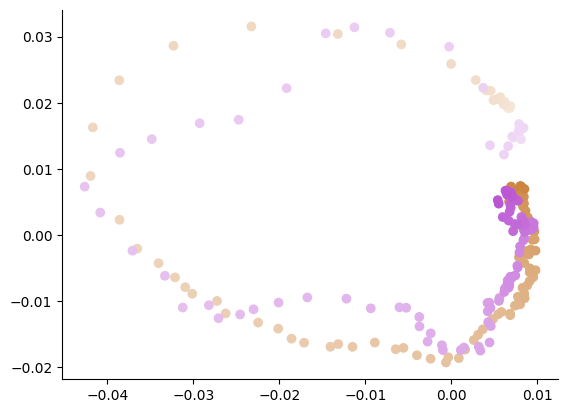

In [33]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.scatter(A_1_trials_mean[:,0], 
          A_1_trials_mean[:,1], 
          #A_1_trials_mean[:,2],
          color = return_timebin_cmap(get_area_color(area_1), n_time_bins),
          linewidths=1)

ax.scatter(A_2_trials_mean[:,0], 
          A_2_trials_mean[:,1], 
          #A_2_trials_mean[:,2],
          color = return_timebin_cmap(get_area_color(area_2), n_time_bins))




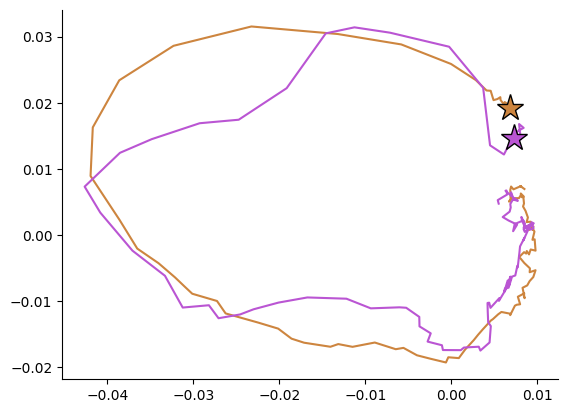

In [34]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

# Trajectories of trial-averages
ax.plot(A_1_trials_mean[:,0], 
          A_1_trials_mean[:,1], 
          #A_1_trials_mean[:,2],
          color = get_area_color(area_1))

ax.plot(A_2_trials_mean[:,0], 
          A_2_trials_mean[:,1], 
          #A_2_trials_mean[:,2],
          color = get_area_color(area_2))

# Starting points
ax.plot(A_1_trials_mean[0,0], 
          A_1_trials_mean[0,1], 
          #A_1_trials_mean[:,2],
          color = get_area_color(area_1),
          marker='*',
          mec='k',
          ms=20)

ax.plot(A_2_trials_mean[0,0], 
          A_2_trials_mean[0,1], 
          #A_2_trials_mean[:,2],
          color = get_area_color(area_2),
          marker='*',
          mec='k',
          ms=20)




#### Mean over time

In [21]:
A_1_trials_trials = np.mean(A_1_trials,axis=1)
A_2_trials_trials = np.mean(A_2_trials,axis=1)
print(A_1_trials_trials.shape, A_2_trials_trials.shape)

n_trials = A_1_trials_trials.shape[0]

(41, 50) (41, 50)


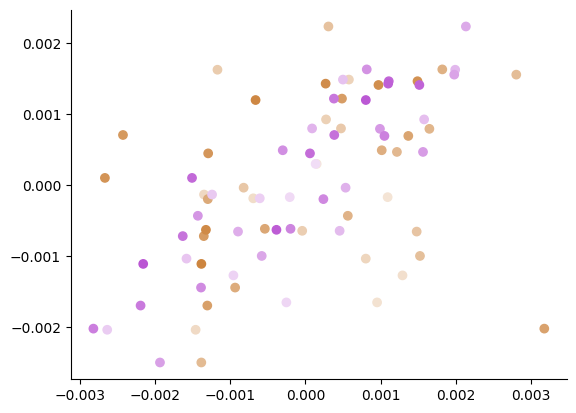

In [22]:
fig, ax = plt.subplots(1,1)
remove_top_right_frame(ax)

ax.scatter(A_1_trials_trials[:,0], 
          A_2_trials_trials[:,1], 
          #A_1_trials_mean[:,2],
          color = return_timebin_cmap(get_area_color(area_1), n_trials),
          linewidths=1)

ax.scatter(A_2_trials_trials[:,0], 
          A_2_trials_trials[:,1], 
          #A_2_trials_mean[:,2],
          color = return_timebin_cmap(get_area_color(area_2), n_trials))




# TODO :
- CV correct with test (return from align) but test data should be trials
- check smoothing
- always compare with PC (return from align)
- residuals (remove mean per condition to each neuron/condition) -> project actual data
-